<a href="https://colab.research.google.com/github/ggeorgol/alphaGenome_tests/blob/training/alphaGenome_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Imports

In [3]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
dna_model = dna_client.create(colab_utils.get_api_key())

In [5]:
output_metadata = dna_model.output_metadata(
    dna_client.Organism.HOMO_SAPIENS
).concatenate()

In [6]:
output_metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,nonzero_mean,output_type,gtex_tissue,histone_mark,transcription_factor
0,CL:0000084 ATAC-seq,.,ATAC-seq,CL:0000084,T-cell,primary_cell,adult,encode,paired,False,0.739741,OutputType.ATAC,NaN,NaN,NaN
1,CL:0000100 ATAC-seq,.,ATAC-seq,CL:0000100,motor neuron,in_vitro_differentiated_cells,adult,encode,paired,False,0.273136,OutputType.ATAC,NaN,NaN,NaN
2,CL:0000236 ATAC-seq,.,ATAC-seq,CL:0000236,B cell,primary_cell,adult,encode,paired,False,4.700081,OutputType.ATAC,NaN,NaN,NaN
3,CL:0000623 ATAC-seq,.,ATAC-seq,CL:0000623,natural killer cell,primary_cell,adult,encode,paired,False,0.938715,OutputType.ATAC,NaN,NaN,NaN
4,CL:0000624 ATAC-seq,.,ATAC-seq,CL:0000624,"CD4-positive, alpha-beta T cell",primary_cell,adult,encode,paired,False,4.365206,OutputType.ATAC,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,ENCSR182QNJ,-,PRO-cap,EFO:0001099,Caco-2,cell_line,NaN,encode,NaN,False,14.002803,OutputType.PROCAP,NaN,NaN,NaN
8,ENCSR740IPL,-,PRO-cap,EFO:0002067,K562,cell_line,NaN,encode,NaN,False,15.765458,OutputType.PROCAP,NaN,NaN,NaN
9,ENCSR797DEF,-,PRO-cap,EFO:0002819,Calu3,cell_line,NaN,encode,NaN,False,12.281321,OutputType.PROCAP,NaN,NaN,NaN
10,ENCSR801ECP,-,PRO-cap,CL:0002618,endothelial cell of umbilical vein,primary_cell,NaN,encode,NaN,False,13.973692,OutputType.PROCAP,NaN,NaN,NaN


In [7]:
seq='CCAGTGGTTTGGGGACATGCTTCCTGGAGTCTTATCCCCTCTTGTCAGATTCAGGTTTAGGACAACGGTACAGTTGTTCCATTGTTCCCAGATAACATATCCTATCTTAACGTCTTTGCTGGGGCAGCCCTTGGACACACCCTGAGCTCCTGCCCTATCACTGGCCCCACTTGTACCCCTTGTGGGCAGGCACCACGGCAGCCTGCTCTGAAGGGAGCTTTCATGTGGCCGACCAACTCTACTCCTTGACTCCTCCCTTCTCTCATTGAAAAAAAATGTTTAAGGGGACATTTCTCTCTCC'

In [8]:
print(len(seq))

301


In [118]:
pvt1_interval=genome.Interval(chromosome = 'chr8', start=128045021, end=128045321)
cdh1_promoter=genome.Interval(chromosome='chr16', start=68737015, end=68737574)
cdh1_hs2=genome.Interval(chromosome='chr16', start=68724838, end=68725290)

In [119]:
interval=cdh1_hs2.resize(dna_client.SEQUENCE_LENGTH_1MB)
interval

Interval(chromosome='chr16', start=68200776, end=69249352, strand='.', name='')

In [148]:
ont_term=['EFO:0002067','CL:0000765'] # K562 and erythroblast

In [149]:
output = dna_model.predict_interval(
    #sequence=seq.center(131072, 'N'),  # Pad to valid sequence length.
    interval=interval,
    requested_outputs=[
        dna_client.OutputType.DNASE,
        dna_client.OutputType.ATAC,
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CHIP_HISTONE,
        dna_client.OutputType.CHIP_TF
        ],
    ontology_terms=ont_term
)

In [150]:
atac=output.atac
dnase=output.dnase
chip=output.chip_histone
rna=output.rna_seq
tf=output.chip_tf

In [151]:
tf.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,transcription_factor,data_source,endedness,genetically_modified,nonzero_mean
0,CL:0000765 TF ChIP-seq POLR2A,.,TF ChIP-seq,CL:0000765,erythroblast,primary_cell,unknown,POLR2A,encode,single,False,0.705191
1,EFO:0002067 TF ChIP-seq ADNP stably expressing...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,ADNP,encode,single,True,0.663443
2,EFO:0002067 TF ChIP-seq AFF1,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,AFF1,encode,paired,False,0.691803
3,EFO:0002067 TF ChIP-seq AFF4 genetically modif...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,AFF4,encode,single,True,0.827890
4,EFO:0002067 TF ChIP-seq AGO1,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,AGO1,encode,single,False,1.243037
...,...,...,...,...,...,...,...,...,...,...,...,...
302,EFO:0002067 TF ChIP-seq ZNF740 stably expressi...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,ZNF740,encode,single,True,0.760980
303,EFO:0002067 TF ChIP-seq ZNF766 genetically mod...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,ZNF766,encode,single,True,0.695731
304,EFO:0002067 TF ChIP-seq ZNF778 genetically mod...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,ZNF778,encode,paired,True,0.774744
305,EFO:0002067 TF ChIP-seq ZNF83 stably expressin...,.,TF ChIP-seq,EFO:0002067,K562,cell_line,adult,ZNF83,encode,single,True,0.745400


In [175]:
filt=tf.metadata.ontology_curie.isin(['CL:0000765']).values

In [176]:
tf.values[:,filt]

array([[95.5],
       [83. ],
       [83. ],
       ...,
       [55.5],
       [71.5],
       [80. ]], dtype=float32)

In [125]:
# The GTF file contains information on the location of all trancripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

In [126]:
# Set up transcript extractors using the information in the GTF file.
# Subset the gtf object to include only rows where gene_name is "PVT1" or "MYC"
#gtf_sub =gtf[gtf['gene_name'].isin(["PVT1", "MYC"])]
gtf_transcripts = gene_annotation.filter_to_longest_transcript(gtf)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)
longest_transcripts = transcript_extractor.extract(cdh1_promoter.resize(1000000))

In [132]:
ans=[plot_components.IntervalAnnotation([cdh1_promoter.resize(1000)], alpha=.25, colors='red'),
                 plot_components.IntervalAnnotation([cdh1_hs2.resize(1000)], alpha=.25, colors='red')]

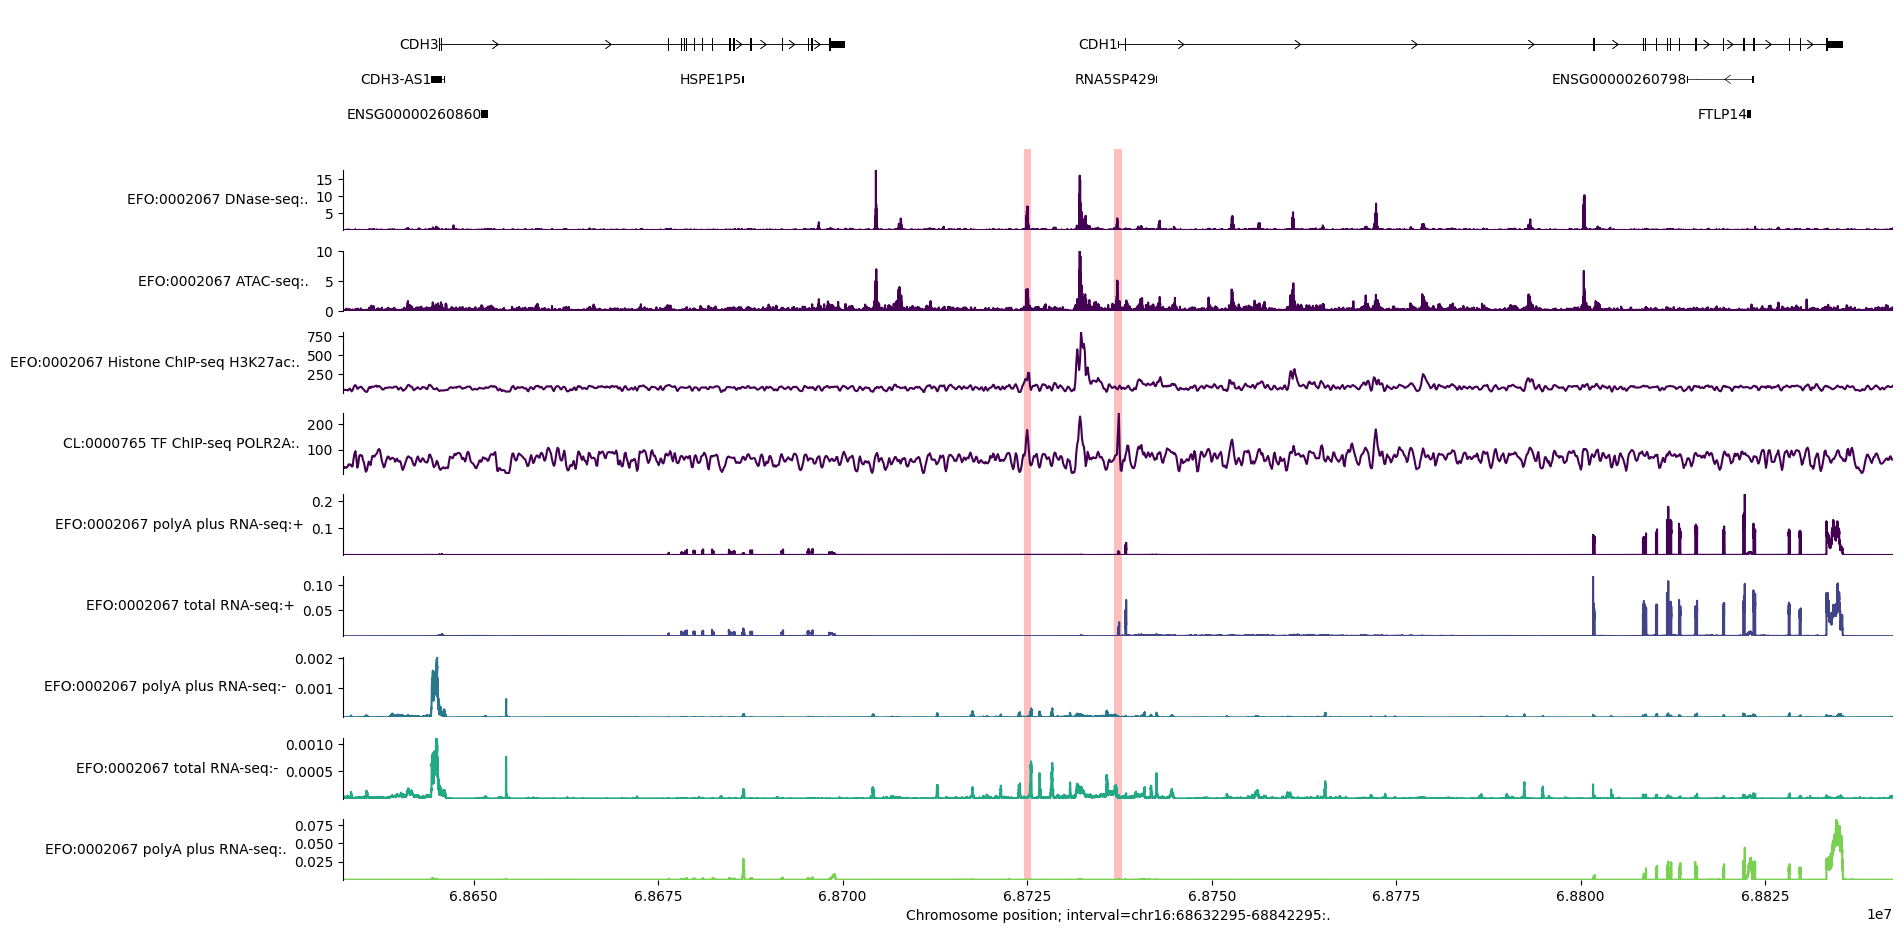

In [177]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(dnase),
        plot_components.Tracks(atac),
        plot_components.Tracks(chip.filter_tracks(chip.metadata['histone_mark'].isin(["H3K27ac"]).values)),
        plot_components.Tracks(tf.filter_tracks(filt)),
        plot_components.Tracks(rna)
    ],
    interval=cdh1_promoter.resize(width=210000),
    annotations=ans
)

plt.show()

## Predict variant effects

In [75]:
#ref='CTTTGCTGGGGCAGCC'
ref=seq

In [135]:
cdh1_promoter_seq='TCTGATCCCAGGTCTTAGTGAGCCACCGGCGGGGCTGGGATTCGAACCCAGTGGAATCAGAACCGTGCAGGTCCCATAACCCACCTAGACCCTAGCAACTCCAGGCTAGAGGGTCACCGCGTCTATGCGAGGCCGGGTGGGCGGGCCGTCAGCTCCGCCCTGGGGAGGGGTCCGCGCTGCTGATTGGCTGTGGCCGGCAGGTGAACCCTCAGCCAATCAGCGGTACGGGGGGCGGTGCCTCCGGGGCTCACCTGGCTGCAGCCACGCACCCCCTCTCAGTGGCGTCGGAACTGCAAAGCACCTGTGAGCTTGCGGAAGTCAGTTCAGACTCCAGCCCGCTCCAGCCCGGCCCGACCCGACCGCACCCGGCGCCTGCCCTCGCTCGGCGTCCCCGGCCAGCCATGGGCCCTTGGAGCCGCAGCCTCTCGGCGCTGCTGCTGCTGCTGCAGGTACCCCGGATCCCCTGACTTGCGAGGGACGCATTCGGGCCGCAAGCTCCGCGCCCCAGCCCTGCGCCCCTTCCTCTCCCGTCGTCACCGCTTCCCTTCTTCCAAGAAAGT'
cdh1_hs2_seq='AGAGAGCCCTTTGTCTCCAAACATCTTTGGTGTGGGGCTAGGCTGAACTTGGCAGGGAGTGGTTTCATTGGCTGCCGAGCCAGCAGAGGGTTGGTTGGGGAAGGGTTTATCTCTCCGTCCCAAGTAGACAGAGTTCTGGCACCTGATTCCCTTGCTCTGAGAAGAGGGTGGGGCCTTCTTTGCTTGGAAGCGGGGGACAGGAAGCAACAGGTCCCTGGGCCTCCACAGTTATGAACTGCAGCACCTTATCTATTGTTCTTGAGATGCCAGGTCCAAAGGTATCTGAGCAGTGGGAGGACACCCAGTCAGCCACAGGGCTCCATGACAGCAGCCCCACTTTCCAGGGGGCTTAACTCACTCCACTTAAGTTGGAGGGGCCTGCTGCCCATGGACTTGGTTCAGGAAAAATCTTGTCCCCTGAGTAATGTGGAATATGGAAATAATAGTTCACGT'

In [88]:
cdh1_promoter

Interval(chromosome='chr16', start=68737015, end=68737574, strand='.', name='')

In [76]:
import random
# Shuffle reference sequence
alt = ''.join(random.sample(ref, len(ref)))

In [136]:
alt='' # Deletion

In [137]:
variant = genome.Variant(
    chromosome=cdh1_hs2.chromosome,
    position=cdh1_hs2.start,
    reference_bases=ref,
    alternate_bases=alt,
)

In [178]:
variant_output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs=[
        dna_client.OutputType.DNASE,
        dna_client.OutputType.ATAC,
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CHIP_HISTONE,
        dna_client.OutputType.CHIP_TF
                       ],
    ontology_terms=ont_term
)

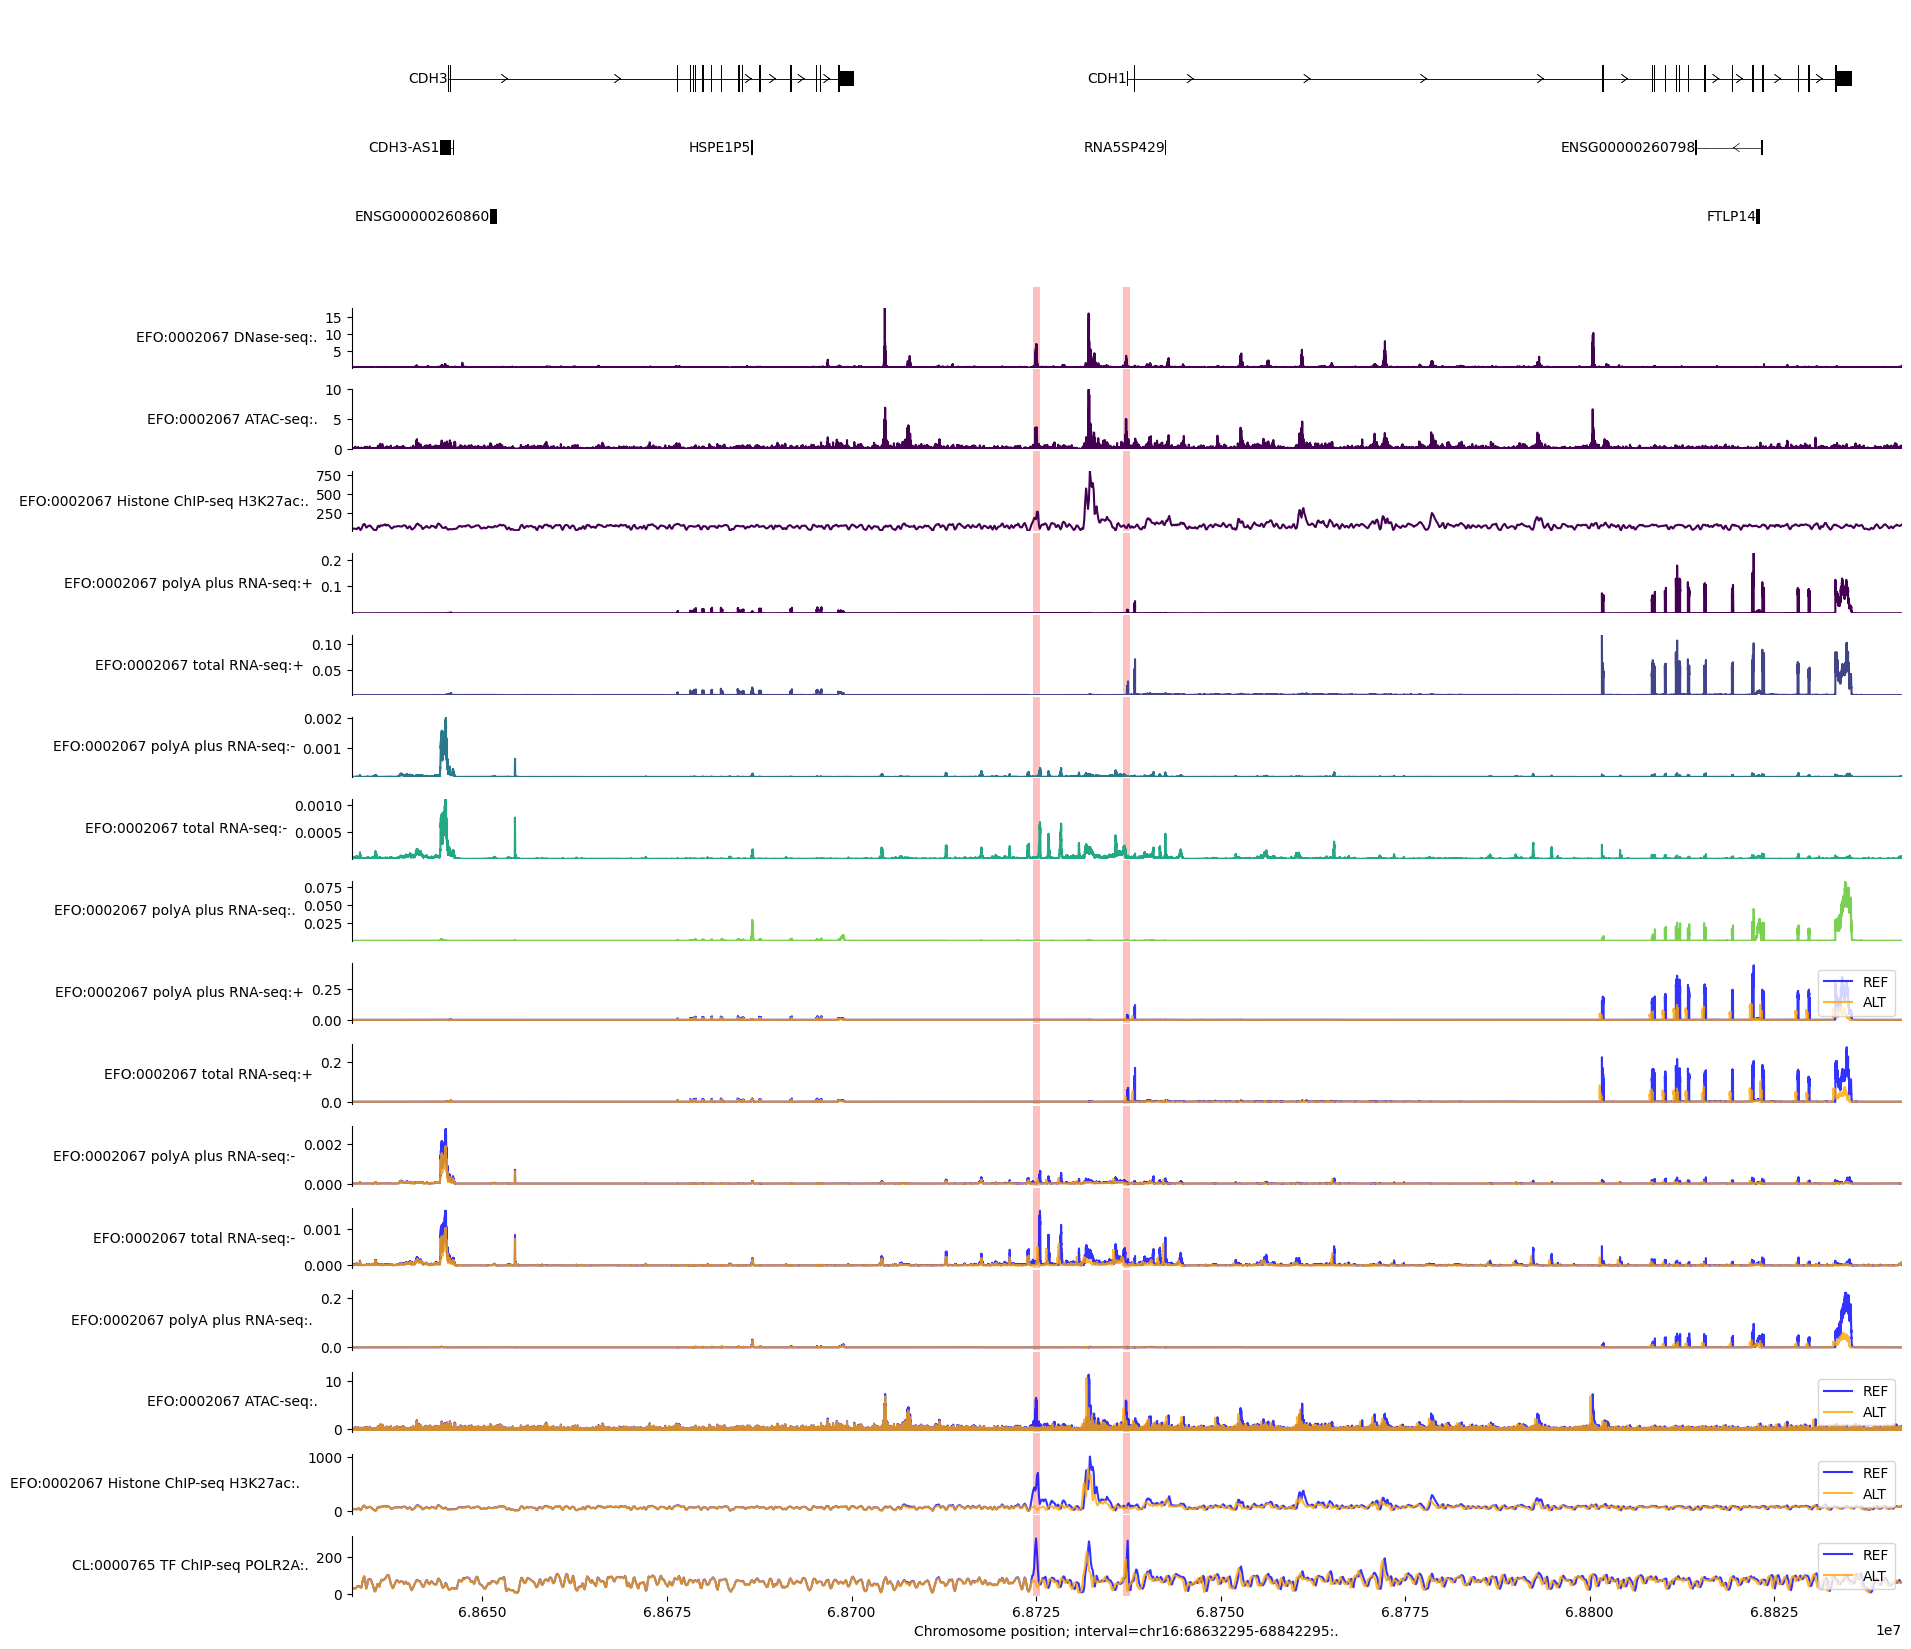

In [179]:
plot_components.plot(
    annotations=ans,
    components=[
        plot_components.TranscriptAnnotation(longest_transcripts, fig_height = 2),
        plot_components.Tracks(dnase),
        plot_components.Tracks(atac),
        plot_components.Tracks(chip.filter_tracks(chip.metadata['histone_mark'].isin(["H3K27ac"]).values)),
        plot_components.Tracks(rna),
        plot_components.OverlaidTracks(
            tdata={
                'ALT': variant_output.alternate.rna_seq,
                'REF': variant_output.reference.rna_seq,
            },
            colors={'REF': 'blue', 'ALT': 'orange'},
        ),
        plot_components.OverlaidTracks(
            tdata={
                'ALT': variant_output.alternate.atac,
                'REF': variant_output.reference.atac,
            },
            colors={'REF': 'blue', 'ALT': 'orange'},
        ),
        plot_components.OverlaidTracks(
            tdata={
                'ALT': variant_output.alternate.chip_histone.filter_tracks(variant_output.alternate.chip_histone.metadata['histone_mark'].isin(['H3K27ac']).values),
                'REF': variant_output.reference.chip_histone.filter_tracks(variant_output.alternate.chip_histone.metadata['histone_mark'].isin(['H3K27ac']).values),
            },
            colors={'REF': 'blue', 'ALT': 'orange'},
        ),
        plot_components.OverlaidTracks(
            tdata={
                'ALT': variant_output.alternate.chip_tf.filter_tracks(filt),
                'REF': variant_output.reference.chip_tf.filter_tracks(filt),
            },
            colors={'REF': 'blue', 'ALT': 'orange'},
        )
    ],
    interval=cdh1_promoter.resize(width=210000)
)

plt.show()

In [142]:
interval

Interval(chromosome='chr8', start=127520883, end=128569459, strand='.', name='')